In [62]:
import numpy as np
import math
from scipy.fft import fft, ifft, fftfreq
import matplotlib.pyplot as plt

## Signal generation

In [289]:
T = 0.001 # Sample spacing
fs = 1/T # Sampling frequency

x = np.arange(0, 10, .01)
N = len(x)

y = np.sin(a)
y = np.sin(.2 * 2.0 * math.pi * x) + 0.5*np.sin(80.0 * 2.0 * math.pi * x)

## Noise addition

In [290]:
amp = 2*np.sqrt(2)
noise_power = 0.00001 * fs / 2

y += np.random.normal(scale=np.sqrt(noise_power), size=x.shape)

## Plot

[(0.0, 10.0), (-2.0, 2.0)]

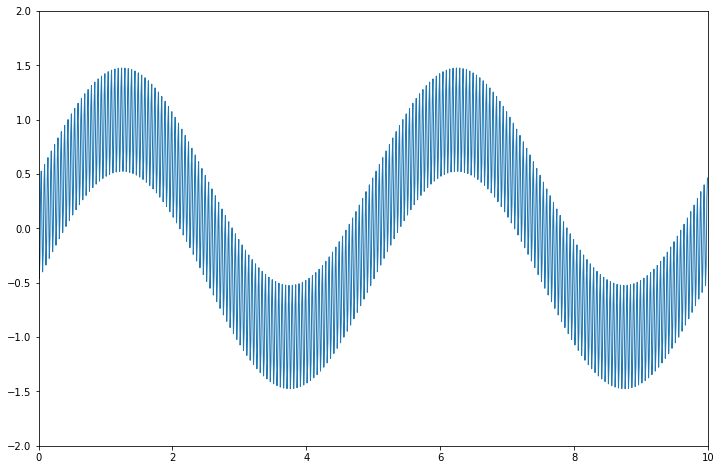

In [87]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(x, y, linewidth=1.0)
ax.set(xlim=(0, 10), ylim=(-2, 2))

## FFT

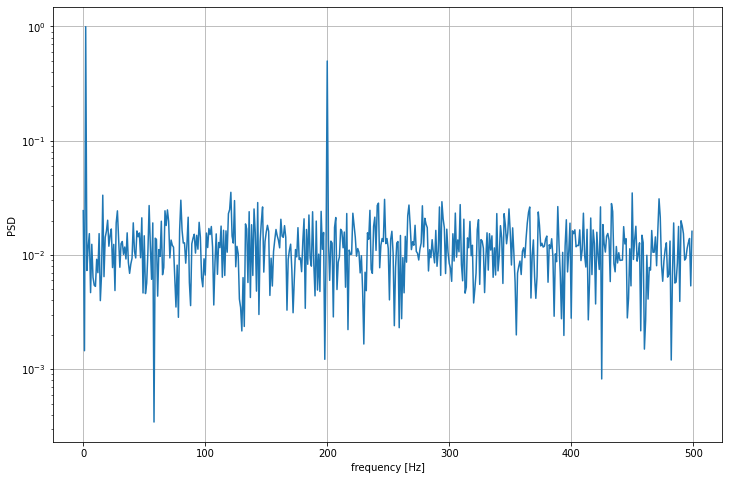

In [67]:
yf = fft(y)
xf = fftfreq(N, T)[:N//2]

fig, ax = plt.subplots(figsize=(12, 8))

ax.semilogy(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
plt.grid()

## Spectrum analyser

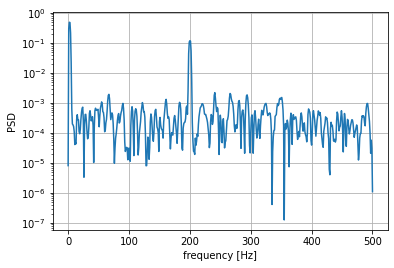

In [68]:
import scipy.signal as signal
f, Pper_spec = signal.periodogram(y, fs, 'flattop', scaling='spectrum')

plt.semilogy(f, Pper_spec)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
plt.grid()

In [88]:
# fs = 200.0  # Sample frequency (Hz)
f0 = 200.0  # Frequency to be removed from signal (Hz)
Q = 20.  # Quality factor
b, a = signal.iirnotch(f0, Q, fs) # Design notch filter

[(0.0, 10.0), (-2.0, 2.0)]

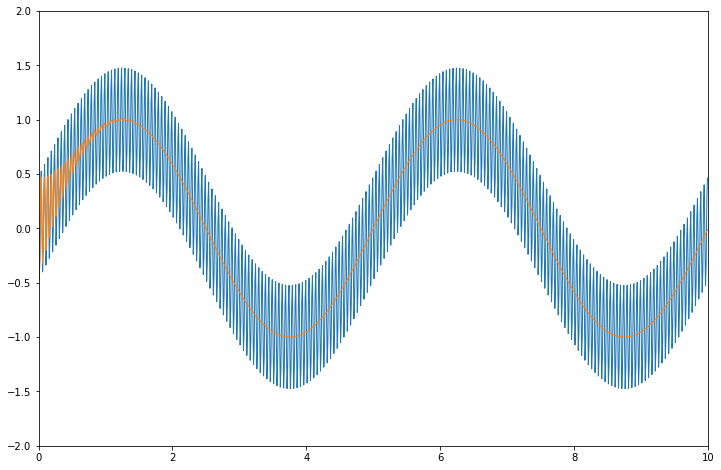

In [89]:
y_f = signal.sosfilt(np.concatenate((b, a)), y, axis=- 1, zi=None)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x, y, x, y_f, linewidth=1.0)
ax.set(xlim=(0, 10), ylim=(-2, 2))

In [96]:
y[:5]
zi = signal.lfiltic(b, a, y[:5])
print(zi)

[0.43475046 0.        ]


(5.6508721498929955,
 array([ 0.        , -0.26237485, -0.50636564, -0.71487643, -0.8732973 ,
        -0.97052802, -0.99975584, -0.95893283, -0.85091936, -0.68328373]))

[(1e-05, 10.0)]

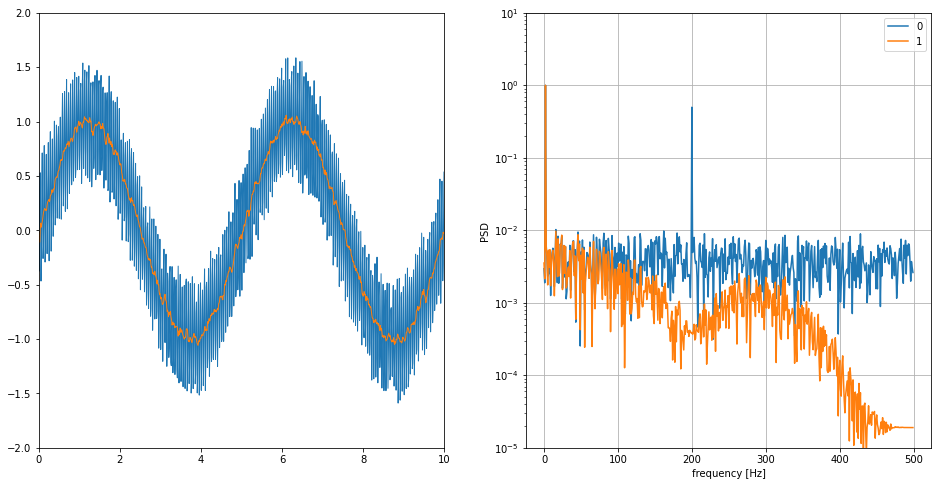

In [163]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 8), ncols=2)

Qs = np.array([.7])

ax1.plot(x, y, linewidth=1.0)
yf = fft(y)
xf = fftfreq(N, T)[:N//2]
ax2.semilogy(xf, 2.0/N * np.abs(yf[0:N//2]))

for Q in Qs:
    b, a = signal.iirnotch(200, Q, fs) # Design notch filter
    y_f = signal.lfilter(b, a, y)

    b, a = signal.butter(4, 300, 'low', fs=fs)
    y_f = signal.lfilter(b, a, y_f)
    
    yf = fft(y_f)
    xf = fftfreq(N, T)[:N//2]
    
    ax1.plot(x, y_f, linewidth=1.0)
    ax1.set(xlim=(0, 10), ylim=(-2, 2))

    ax2.semilogy(xf, 2.0/N * np.abs(yf[0:N//2]))
    
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
plt.grid()

ax2.legend(range(0, 10))
ax2.set(ylim=(1e-5, 1e1))

In [440]:
def phase_array(phase, omega, length):
        return phase + np.linspace(0, length-1, length) * omega

class sin_model:
    def __init__(self, amp0, phase0, omega0):
        self.amp = float(amp0)
        self.phase = float(phase0)
        self.omega_f = float(omega0)
        
        self.damp = 0.001
        self.dphase = math.pi * 0.01
        self.domega_f = 0.01
        
    def omega(self) -> float:
        return 2 * math.pi / self.omega_f
    
    def fun(state_v, data):
        (amp, phase, omega) = state_v
        
        phases = phase_array(phase, 2 * math.pi / omega, len(data));
        y_est = amp * np.sin(phases)
        error = data - y_est
        return np.array([np.sum(error * error)])
    
    def jac(state_v, data):
        (damp, dphase, domega_f) = (0.01, math.pi * 0.001, 0.01)
        (amp, phase, omega) = state_v
        
        err = sin_model.fun(state_v, data)
        
        damp_phase = phase_array(phase, 2 * math.pi / omega, len(data))
        damp_est = (amp + damp) * np.sin(damp_phase)
        damp_err = np.sum((data - damp_est) * (data - damp_est))
        damp_div = (damp_err - err) / damp
        
        dphase_phase = phase_array(phase + dphase, 2 * math.pi / omega, len(data))
        dphase_est = amp * np.sin(dphase_phase)
        dphase_err = np.sum((data - dphase_est) * (data - dphase_est))
        dphase_div = (dphase_err - err) / dphase
        
        domega_phase = phase_array(phase, 2 * math.pi / (omega + domega_f), len(data))
        domega_est = amp * np.sin(domega_phase)
        domega_err = np.sum((data - domega_est) * (data - domega_est))
        domega_div = (domega_err - err) / domega_f
        
        return np.concatenate((damp_div, 
                         dphase_div, 
                         domega_div))
        
        
    def calc_error(self, data):
        phase_values = phase_array(self.phase, self.omega(), len(data));
        est = self.amp * np.sin(phase_values)
        error = data - est
        error_sum = np.sum(error * error)
        
        damp_est = (self.amp + 0.01) * np.sin(phase_values)
        damp_err = np.sum((data - damp_est) * (data - damp_est))
        damp_div = damp_err - error_sum
        
        dphase_phase = phase_array(self.phase + self.dphase, self.omega(), len(data))
        dphase_est = self.amp * np.sin(dphase_phase)
        dphase_err = np.sum((data - dphase_est) * (data - dphase_est))
        dphase_div = dphase_err - error_sum
        
        domega_phase = phase_array(self.phase, self.omega() + 2 * math.pi / self.domega_f, len(data))
        domega_est = self.amp * np.sin(domega_phase)
        domega_err = np.sum((data - domega_est) * (data - domega_est))
        domega_div = domega_err - error_sum
        
        return {
            "error": error_sum,
            "damp_err": damp_err,
            "damp_dif": damp_div,
            "dphase_err": dphase_err,
            "dphase_dif": dphase_div,
            "domega_err": domega_err,
            "domega_dif": domega_div,
            "phase_est": phase_values,
            "y_est": est
        }
        
model = sin_model(1, 0, 50.)
data_in = np.zeros(10)
model.calc_error(data_in)

sin_model.fun(np.array([0, 1, 2]), ())

array([0.])

0.04693905474031226 0.4818319550219325 -0.7609788737426015
-0.32480629192002086 0.2420293146836579 -0.43593960175826396
-0.09649547390058615 0.18251376610178613 -0.3933909306698524
-0.026480429821364736 0.014109448762112614 -0.16533487829235582
-0.0012879240398518733 -0.002679992739806885 -0.1426922198027114
-0.00014792185810392767 -0.0019255862793446635 -0.14265638155961824
-9.486136889051977e-05 -0.0019584220952431884 -0.14147093061183114
-9.015835101990889e-05 -0.0019383120660727369 -0.14036653049714687
-8.733334516932701e-05 -0.0019222137297408338 -0.1392673404143352
-8.465780495896525e-05 -0.001906020600932977 -0.13817902096207035


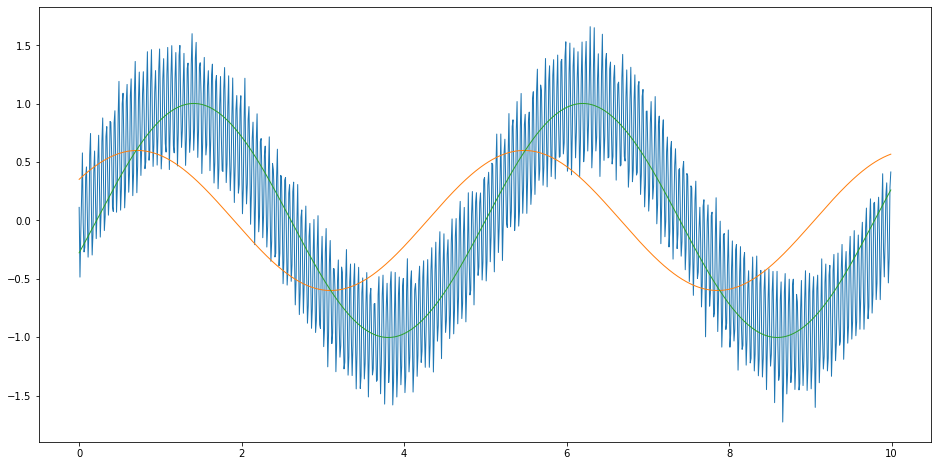

In [457]:
fig, ax1 = plt.subplots(figsize=(16, 8))
ax1.plot(x, y, linewidth=1.0)

model_inputs = np.array([.6, .2 * math.pi, fs / 2.1], dtype = float) 
x_ = model_inputs

model = sin_model(x_[0], x_[1], x_[2])
model_res = model.calc_error(y)
ax1.plot(x, model_res["y_est"], linewidth=1.0)

for idx in range(0, 10):
    err = sin_model.fun(x_, y)
    jac = sin_model.jac(x_, y)
    
    damp = jac[0] * 0.001
    dphase = jac[1] * .001
    domega = jac[2] * .1
    
#     print(jac)
    print(damp, dphase, domega)
    x_ += np.array([-damp, -dphase, -domega])
    
    
model = sin_model(x_[0], x_[1], x_[2])
model_res = model.calc_error(y)
ax1.plot(x, model_res["y_est"], linewidth=1.0)

# model_res.pop("y_est")
# model_res.pop("phase_est")
# print(model_res)

In [365]:
from scipy import optimize

data = y
sol = optimize.root(sin_model.fun, [1, 0, 50], args=(data), jac=sin_model.jac, method='hybr')

sol.x

TypeError: fsolve: there is a mismatch between the input and output shape of the 'func' argument 'fun'.Shape should be (3,) but it is (1,).